# Figs of Horizontal Turner Angles
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Global annual-mean](#first-bullet)
* [Basin-wide annual-mean](#second-bullet)
* [Global timeseries?](#third-bullet)

> Note: the time dimension is only for first 6 months of CESM data

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [5]:
import json
with open('/home/jovyan/chapter2/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ta = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/turner_angle.zarr'))
ta

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import json
import fsspec
import gcsfs
import xmitgcm
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU']])

In [3]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds_drop)

In [4]:
def horizontal_turner_angle():
    """Compute horizontal turner angle given SST and SSS, 
        and user-defined basin selection"""
    
    def gradient(da):
        """Compute the gradients of T, S and rho"""
        
        da_diffx = grid.diff(da, 'X')
        da_diffy = grid.diff(da, 'Y', boundary='fill')
        da_diffx_interp = grid.interp(da_diffx, 'X')
        da_diffy_interp = grid.interp(da_diffy, 'Y', boundary='fill')
        dadx = da_diffx_interp/ds_ren.DXT
        dady = da_diffy_interp / ds_ren.DYT
        return dadx, dady
    
    #create grad-rho and |grad-rho| terms
    #rho = jmd95numba.rho(ds_ren.SSS, ds_ren.SST, 0).load()
    rho = xr.apply_ufunc(jmd95numba.rho, ds_ren.SSS, ds_ren.SST, 0,
                     output_dtypes=ds_ren.SST.dtype,
                     dask='parallelized', vectorize=True).reset_coords(drop=True)
    gradrho = gradient(rho)
    modgradrho = 1 / np.sqrt(gradrho[0]**2 + gradrho[-1]**2)
    
    #create gradT and gradS
    gradT = gradient(ds_ren.SST)
    gradS = gradient(ds_ren.SSS)
    
    #define alpha and beta
    runit2mass = 1.035e3 #rho_0
    drhodt = xr.apply_ufunc(jmd95numba.drhodt, ds_ren.SSS, ds_ren.SST, 0,
                        output_dtypes=[ds_ren.SST.dtype],
                        dask='parallelized', vectorize=True).reset_coords(drop=True)#.load()
    drhods = xr.apply_ufunc(jmd95numba.drhods, ds_ren.SSS, ds_ren.SST, 0,
                        output_dtypes=[ds_ren.SSS.dtype],
                        dask='parallelized', vectorize=True).reset_coords(drop=True)#.load()
    alpha = - drhodt / runit2mass
    beta = drhods / runit2mass
    
    #define eq
    #gradrho[0/1] is selecting the dadx/dady output from `gradient` func above
    term1 = modgradrho*(gradrho[0]*(alpha*gradT[0] + beta*gradS[0]) + gradrho[1]*(alpha*gradT[1] + beta*gradS[1]))
    term2 = modgradrho*(gradrho[0]*(alpha*gradT[0] - beta*gradS[0]) + gradrho[1]*(alpha*gradT[1] - beta*gradS[1]))
    turner_angle = xr.ufuncs.arctan(term1, term2)
    
    return turner_angle

In [5]:
#weddell region
selection = dict(time=10, nlon_t=slice(470, 1000), nlat_t=slice(0,500))

#### Plot Turner angle

In [6]:
ta = horizontal_turner_angle()

/tmp/ipykernel_479/4172090642.py:43: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  turner_angle = xr.ufuncs.arctan(term1, term2)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataarray.py:3098: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/variable.py:2467: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


In [7]:
ta

<xarray.DataArray (time: 14965, nlat_t: 2400, nlon_t: 3600)>
dask.array<arctan, shape=(14965, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
    DXT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: time

In [14]:
ta_deg = xr.ufuncs.degrees(ta)

/tmp/ipykernel_479/1649012236.py:1: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  ta_deg = xr.ufuncs.degrees(ta)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataarray.py:3078: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


In [24]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [25]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.21bc82f44e864abda0cdedb2f9423278/status,


In [38]:
client.close()
cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


# 1) Global annual-mean <a class='anchor' id='first-bullet'> </a>

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/function_base.py:2418: RuntimeWarning: invalid value encountered in drhodt
  results = func(*(arg[index] for arg in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/function_base.py:2418: RuntimeWarning: invalid value encountered in rho
  results = func(*(arg[index] for arg in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/function_base.py:2418: RuntimeWarning: invalid value encountered in drhods
  results = func(*(arg[index] for arg in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


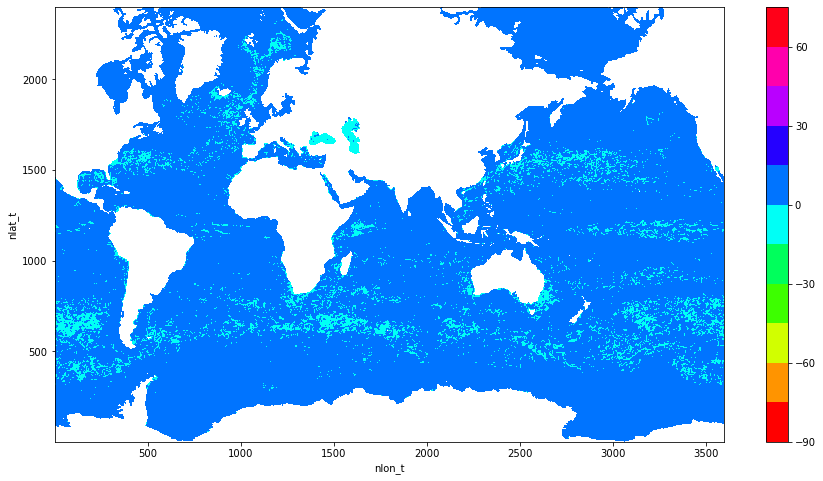

In [15]:
#global turner angle
fig, ax = plt.subplots(figsize=(15,8))
ta_deg.isel(time=10).plot.contourf(levels=np.arange(-90, 90, 15), cmap='hsv');

# 2) Basin-wide annual-mean <a class='anchor' id='second-bullet'> </a>